In [6]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw

molecule is [rapamycin](https://pubchem.ncbi.nlm.nih.gov/compound/rapamycin#section=2D-Structure)

In [12]:
rapamycin_SMILES = 'CC1CCC2CC(C(=CC=CC=CC(CC(C(=O)C(C(C(=CC(C(=O)CC(OC(=O)C3CCCCN3C(=O)C(=O)C1(O2)O)C(C)CC4CCC(C(C4)OC)O)C)C)O)OC)C)C)C)OC'
ramapycin_SMILES_isomeric = 'C[C@@H]1CC[C@H]2C[C@@H](/C(=C/C=C/C=C/[C@H](C[C@H](C(=O)[C@@H]([C@@H](/C(=C/[C@H](C(=O)C[C@H](OC(=O)[C@@H]3CCCCN3C(=O)C(=O)[C@@]1(O2)O)[C@H](C)C[C@@H]4CC[C@H]([C@@H](C4)OC)O)C)/C)O)OC)C)C)/C)OC'

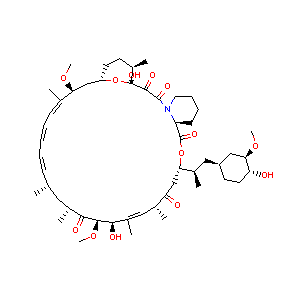

In [33]:
mol = Chem.rdmolfiles.MolFromSmiles(ramapycin_SMILES_isomeric)
Draw.MolToImage(mol, size=(300, 300), wedgeBonds=True)

maximal common substructure code

In [29]:
import pandas as pd
from rdkit.Chem import rdFMCS

In [27]:
# gets a df containing SMILES strings of products
df = pd.DataFrame([["C#CCP"],["C=CCO"]])
# converts product column to list
mol_list = list(df[0])

# converts SMILES strings to molecule objects
for i in range(len(mol_list)):
    mol_list[i] = Chem.MolFromSmiles(mol_list[i])


In [31]:
# finds maximum common substructure among list of molecule objects
def get_mcs(products_df):      
    
    mol_list = list(products_df[0])

    for i in range(len(mol_list)):
        mol_list[i] = Chem.MolFromSmiles(mol_list[i])

    maximum_common_substructure = rdFMCS.FindMCS(mol_list)
    
return maximum_common_substructure

#Draw.MolToImage(maximum_common_substructure, size=(300, 300), kekulize=False, wedgeBonds=True)

molecular similarity between maximal common substructure and each product

In [ ]:
with input as enzyme_products_df
    
    mcs = get_mcs(input)
    
    distance_list = []
    
    for index, row in input.itterrows():
        distance = #distance score to mcs
        distance_list.append(distance)
    
    return distance_list

average similarity value

In [43]:
def avg_similarity(distance_list):
    
    return sum(distance_list)/len(distance_list)